In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc

CPU times: user 1.79 s, sys: 901 ms, total: 2.69 s
Wall time: 3.14 s


In [2]:
df = pd.read_csv("train.csv", low_memory = False)
df['product'] = df['product'].astype('category')
sizes = 'Kaggle Sticker', 'Kaggle Mug', 'Kaggle Hat'
df['product'].cat.set_categories(sizes, ordered = True, inplace = True)
sizes = 'KaggleRama', 'KaggleMart'
df['store'] = df['store'].astype('category')
df['store'].cat.set_categories(sizes, ordered = True, inplace = True)
dep_var = "num_sold"

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [3]:
%%time
df = add_datepart(df, 'date')

CPU times: user 62.4 ms, sys: 165 µs, total: 62.6 ms
Wall time: 60.2 ms


In [4]:
cond = (df.Year < 2018)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [5]:
splits = (list(train_idx), list(valid_idx))
cont, cat = cont_cat_split(df, 1, dep_var)

In [6]:
cont

['row_id', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Elapsed']

In [7]:
cont.remove("row_id")

In [8]:
procs = [Categorify, FillMissing]
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [9]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [10]:
def calculate_smape(m, valid_xs, valid_y):
    preds = list(m.predict(valid_xs))
    total = len(preds)
    smape = 0
    for i,j in zip(preds, valid_y) :
        diff = np.abs(i - j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smape += fin
        
    smape = (smape/total) * 100 
    
    return smape

In [11]:
def rf(xs, y, n_estimators = 20, max_samples = 9800, max_features = 0.5, min_samples_leaf = 5, **kwargs):
    return RandomForestRegressor(n_estimators = n_estimators, n_jobs = -1, max_features = max_features, max_samples = max_samples,
                                 min_samples_leaf = min_samples_leaf, oob_score = True).fit(xs, y)

In [12]:
%%time
m = rf(xs, y)

CPU times: user 634 ms, sys: 14.4 ms, total: 648 ms
Wall time: 217 ms


In [13]:
calculate_smape(m, xs, y)

5.012935044328139

In [14]:
calculate_smape(m, valid_xs, valid_y)

14.489232461181661

In [15]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols' : df.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)

In [16]:
fi = rf_feat_importance(m, xs)

In [17]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize = (12, 7), legend = False)

<AxesSubplot:ylabel='cols'>

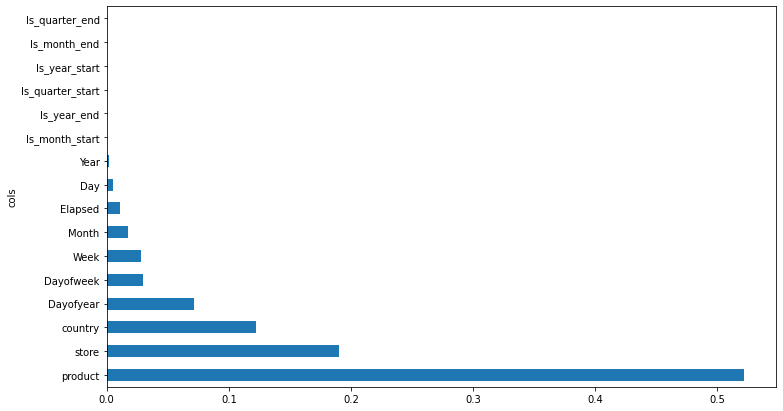

In [18]:
plot_fi(fi)

In [19]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

9

In [20]:
%%time
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

CPU times: user 507 ms, sys: 15.1 ms, total: 522 ms
Wall time: 193 ms


In [21]:
calculate_smape(m, xs_imp, y)

5.102351422289524

In [22]:
calculate_smape(m, valid_xs_imp, valid_y)

10.691538881766933

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


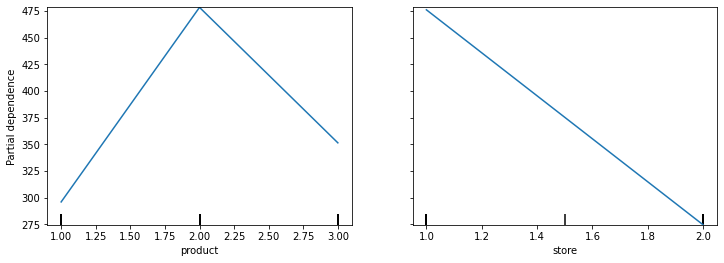

In [23]:
fig, ax = plt.subplots(figsize = (12, 4))
plot_partial_dependence(m, valid_xs, ['product', 'store'], 
                        grid_resolution = 20, ax = ax)

In [24]:
df["product"].unique()

['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']
Categories (3, object): ['Kaggle Sticker' < 'Kaggle Mug' < 'Kaggle Hat']

In [25]:
df_nn = pd.read_csv("train.csv", low_memory = False)
df_nn['product'] = df_nn['product'].astype('category')
sizes = 'Kaggle Sticker', 'Kaggle Mug', 'Kaggle Hat'
df_nn['product'].cat.set_categories(sizes, ordered = True, inplace = True)
sizes = 'KaggleRama', 'KaggleMart'
df_nn['store'] = df_nn['store'].astype('category')
df_nn['store'].cat.set_categories(sizes, ordered = True, inplace = True)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [26]:
df_nn = add_datepart(df_nn, 'date')

In [27]:
df_nn_final = df_nn[list(xs_imp.columns) + [dep_var]]

In [28]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card = 9000, dep_var = dep_var)

In [29]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs, cat_nn, cont_nn, y_names = dep_var, splits = splits)

In [30]:
dls = to_nn.dataloaders(1024, device = "cuda")

In [31]:
learn = tabular_learner(dls, y_range = (69, 2808), n_out = 1, layers = [500, 250])

In [32]:
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,time
0,931436.375000,93484.320312,00:00
1,422338.750000,217655.015625,00:00
2,268081.781250,194226.281250,00:00
3,175397.578125,96771.554688,00:00
4,115256.507812,15176.389648,00:00
5,76077.671875,6197.448242,00:00
6,51254.054688,5261.745117,00:00
7,35026.000000,4558.931152,00:00
8,24241.560547,4578.417969,00:00
9,17037.966797,4486.085938,00:00


In [33]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(367, 44)
    (4): Embedding(8, 5)
    (5): Embedding(54, 15)
    (6): Embedding(13, 7)
    (7): Embedding(32, 11)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=92, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=250, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=250, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=69, high=2808)
  )
)

In [34]:
embs = [param for param in learn.model.embeds.parameters()]

In [35]:
len(embs), len(cat_nn)

(8, 8)

In [36]:
to.cat_names

(#9) ['country','store','product','Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start']

In [37]:
emb_dict = {}
cats = list(to.cat_names)

for i,j in zip(cats, embs) :
    j = j.to(device = "cpu")
    j = j.detach().numpy()
    emb_dict[i] = j

In [38]:
emb_dict.keys()

dict_keys(['country', 'store', 'product', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end'])

In [39]:
emb_dict['country']

array([[ 0.01356119,  0.01118535,  0.01405186],
       [ 0.49851698,  0.16572799,  0.44117638],
       [-0.22997577, -0.31350416, -0.36796924],
       [-1.012257  , -0.8346111 , -0.7070108 ]], dtype=float32)

In [40]:
emb_dim = emb_dict['country'].shape[1]
emb_dim

3

In [41]:
cat = to.procs.categorify
country_cat = cat['country']
country_cat

['#na#', 'Finland', 'Norway', 'Sweden']

In [42]:
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
country_map = {country_cat[i] : emb_dict['country'][i] for i in range(len(country_cat))}
df_emb_country = pd.DataFrame(df_nn_final['country'].map(country_map).to_list(), columns = col_name)

In [43]:
df_emb_country.head()

,country_emb_1,country_emb_2,country_emb_3
0,0.498517,0.165728,0.441176
1,0.498517,0.165728,0.441176
2,0.498517,0.165728,0.441176
3,0.498517,0.165728,0.441176
4,0.498517,0.165728,0.441176


In [44]:
df_nn_final.head()

,product,store,country,Dayofyear,Dayofweek,Week,Month,Elapsed,Day,num_sold
0,Kaggle Mug,KaggleMart,Finland,1,3,1,1,1.420070e+09,1,329
1,Kaggle Hat,KaggleMart,Finland,1,3,1,1,1.420070e+09,1,520
2,Kaggle Sticker,KaggleMart,Finland,1,3,1,1,1.420070e+09,1,146
3,Kaggle Mug,KaggleRama,Finland,1,3,1,1,1.420070e+09,1,572
4,Kaggle Hat,KaggleRama,Finland,1,3,1,1,1.420070e+09,1,911


In [45]:
df_nn_final.tail()

,product,store,country,Dayofyear,Dayofweek,Week,Month,Elapsed,Day,num_sold
26293,Kaggle Hat,KaggleMart,Sweden,365,0,1,12,1.546214e+09,31,823
26294,Kaggle Sticker,KaggleMart,Sweden,365,0,1,12,1.546214e+09,31,250
26295,Kaggle Mug,KaggleRama,Sweden,365,0,1,12,1.546214e+09,31,1004
26296,Kaggle Hat,KaggleRama,Sweden,365,0,1,12,1.546214e+09,31,1441
26297,Kaggle Sticker,KaggleRama,Sweden,365,0,1,12,1.546214e+09,31,388


In [46]:
df_emb_country.tail()

,country_emb_1,country_emb_2,country_emb_3
26293,-1.012257,-0.834611,-0.707011
26294,-1.012257,-0.834611,-0.707011
26295,-1.012257,-0.834611,-0.707011
26296,-1.012257,-0.834611,-0.707011
26297,-1.012257,-0.834611,-0.707011


In [47]:
cat = to.procs.categorify
product_cat = cat['product']
print (product_cat)
emb_dim = emb_dict['product'].shape[1]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
product_map = {product_cat[i] : emb_dict['product'][i] for i in range(len(product_cat))}
df_emb_product = pd.DataFrame(df_nn_final['product'].map(product_map).to_list(), columns = col_name)

['#na#', 'Kaggle Sticker', 'Kaggle Mug', 'Kaggle Hat']


TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


In [48]:
product_map.keys()

dict_keys(['#na#', 'Kaggle Sticker', 'Kaggle Mug', 'Kaggle Hat'])

In [49]:
len(df_emb_product)

26298

In [50]:
len(df_emb_country)

26298

In [51]:
cat = to.procs.categorify
store_cat = cat['store']
print (store_cat)
emb_dim = emb_dict['store'].shape[1]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
store_map = {store_cat[i] : emb_dict['store'][i] for i in range(len(store_cat))}
df_emb_store = pd.DataFrame(df_nn_final['store'].map(store_map).to_list(), columns = col_name)

['#na#', 'KaggleRama', 'KaggleMart']


TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


In [52]:
df_emb_store.head()

,store_emb_1,store_emb_2,store_emb_3
0,0.023705,0.111968,0.133358
1,0.023705,0.111968,0.133358
2,0.023705,0.111968,0.133358
3,0.689716,1.039049,0.618767
4,0.689716,1.039049,0.618767


In [53]:
df_emb_store.tail()

,store_emb_1,store_emb_2,store_emb_3
26293,0.023705,0.111968,0.133358
26294,0.023705,0.111968,0.133358
26295,0.689716,1.039049,0.618767
26296,0.689716,1.039049,0.618767
26297,0.689716,1.039049,0.618767


In [54]:
df_embs = pd.concat([df_emb_country, df_emb_product, df_emb_store], axis = 1)

In [55]:
df_embs.head()

,country_emb_1,country_emb_2,country_emb_3,product_emb_1,product_emb_2,product_emb_3,store_emb_1,store_emb_2,store_emb_3
0,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.023705,0.111968,0.133358
1,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.023705,0.111968,0.133358
2,0.498517,0.165728,0.441176,0.066269,0.244436,0.013940,0.023705,0.111968,0.133358
3,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.689716,1.039049,0.618767
4,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.689716,1.039049,0.618767


In [56]:
df_embs.tail()

,country_emb_1,country_emb_2,country_emb_3,product_emb_1,product_emb_2,product_emb_3,store_emb_1,store_emb_2,store_emb_3
26293,-1.012257,-0.834611,-0.707011,0.127828,-0.086277,0.016927,0.023705,0.111968,0.133358
26294,-1.012257,-0.834611,-0.707011,0.066269,0.244436,0.013940,0.023705,0.111968,0.133358
26295,-1.012257,-0.834611,-0.707011,0.425925,-0.523972,0.226442,0.689716,1.039049,0.618767
26296,-1.012257,-0.834611,-0.707011,0.127828,-0.086277,0.016927,0.689716,1.039049,0.618767
26297,-1.012257,-0.834611,-0.707011,0.066269,0.244436,0.013940,0.689716,1.039049,0.618767


In [57]:
len(df_embs)

26298

In [58]:
df_final = pd.concat([df_nn_final[["Dayofyear", "Dayofweek", "Week", "Month", "Elapsed", "Day", "num_sold"]], df_embs], axis = 1)

In [59]:
df_final.head()

,Dayofyear,Dayofweek,Week,Month,Elapsed,Day,num_sold,country_emb_1,country_emb_2,country_emb_3,product_emb_1,product_emb_2,product_emb_3,store_emb_1,store_emb_2,store_emb_3
0,1,3,1,1,1.420070e+09,1,329,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.023705,0.111968,0.133358
1,1,3,1,1,1.420070e+09,1,520,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.023705,0.111968,0.133358
2,1,3,1,1,1.420070e+09,1,146,0.498517,0.165728,0.441176,0.066269,0.244436,0.013940,0.023705,0.111968,0.133358
3,1,3,1,1,1.420070e+09,1,572,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.689716,1.039049,0.618767
4,1,3,1,1,1.420070e+09,1,911,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.689716,1.039049,0.618767


In [60]:
df_final.tail()

,Dayofyear,Dayofweek,Week,Month,Elapsed,Day,num_sold,country_emb_1,country_emb_2,country_emb_3,product_emb_1,product_emb_2,product_emb_3,store_emb_1,store_emb_2,store_emb_3
26293,365,0,1,12,1.546214e+09,31,823,-1.012257,-0.834611,-0.707011,0.127828,-0.086277,0.016927,0.023705,0.111968,0.133358
26294,365,0,1,12,1.546214e+09,31,250,-1.012257,-0.834611,-0.707011,0.066269,0.244436,0.013940,0.023705,0.111968,0.133358
26295,365,0,1,12,1.546214e+09,31,1004,-1.012257,-0.834611,-0.707011,0.425925,-0.523972,0.226442,0.689716,1.039049,0.618767
26296,365,0,1,12,1.546214e+09,31,1441,-1.012257,-0.834611,-0.707011,0.127828,-0.086277,0.016927,0.689716,1.039049,0.618767
26297,365,0,1,12,1.546214e+09,31,388,-1.012257,-0.834611,-0.707011,0.066269,0.244436,0.013940,0.689716,1.039049,0.618767


In [61]:
#df_final.to_csv("train_embs.csv")

In [62]:
country_map

{'#na#': array([0.01356119, 0.01118535, 0.01405186], dtype=float32),
 'Finland': array([0.49851698, 0.16572799, 0.44117638], dtype=float32),
 'Norway': array([-0.22997577, -0.31350416, -0.36796924], dtype=float32),
 'Sweden': array([-1.012257 , -0.8346111, -0.7070108], dtype=float32)}

In [63]:
product_map

{'#na#': array([ 0.01294461, -0.00381095, -0.01660344], dtype=float32),
 'Kaggle Sticker': array([0.06626856, 0.24443601, 0.01394006], dtype=float32),
 'Kaggle Mug': array([ 0.42592514, -0.52397215,  0.22644173], dtype=float32),
 'Kaggle Hat': array([ 0.12782763, -0.08627668,  0.01692694], dtype=float32)}

In [64]:
store_map

{'#na#': array([-0.00473005, -0.00167127, -0.00394201], dtype=float32),
 'KaggleRama': array([0.6897162 , 1.0390494 , 0.61876696], dtype=float32),
 'KaggleMart': array([0.02370485, 0.11196793, 0.1333581 ], dtype=float32)}

In [65]:
import pickle

In [66]:
with open("product_map.pkl", "wb") as f:
    pickle.dump(product_map, f, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
with open("country_map.pkl", "wb") as f:
    pickle.dump(country_map, f, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
with open("store_map.pkl", "wb") as f:
    pickle.dump(store_map, f, protocol=pickle.HIGHEST_PROTOCOL)